# Adaptation model plots notebook
#### Author: Eddie Lee, edlee@csh.ac.at
This notebook is for plotting the results from the manuscript "Outsourcing Memory Through Niche Construction."

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', size=25)

In [4]:
from pyutils import *
from matplotlib.patches import Rectangle
from misc.plot import colorcycle
from matplotlib.gridspec import GridSpec
from scipy.signal import argrelextrema

# set path to where figures will be saved
imgdr = os.path.expanduser('~')+'/Dropbox/Research/learning/writing/20210227_draft'

# Part of Figure 1

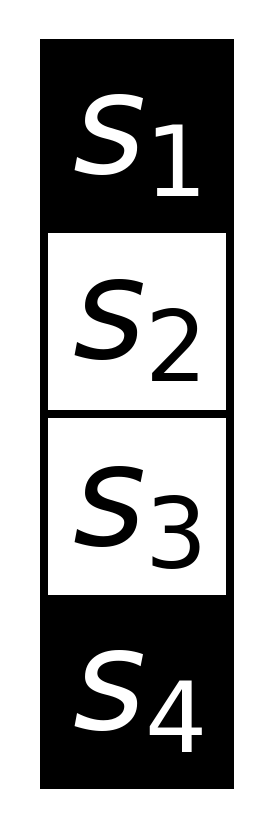

In [63]:
patches = []

for i in range(4):
    patches.append(Rectangle((0,i*10), 10, 10, lw=8, ec='k', color='w' if random.rand()<.5 else 'k'))

fig, ax = plt.subplots(figsize=(10,15),
                       subplot_kw={'aspect':'equal'})

for i, p in enumerate(patches):
    ax.add_patch(p)
    if sum(p.get_fc())==1:
        ax.text(1.5, 3+10*i, r'$s_%d$'%(4-i), fontsize=140, color='w')
    else:
        ax.text(1.5, 3+10*i, r'$s_%d$'%(4-i), fontsize=140)
    
ax.set(xlim=(-2,12), ylim=(-2, 42), xticks=[], yticks=[])
[s.set_visible(False) for s in ax.spines.values()];

In [147]:
fig.savefig('%s/vector.png'%imgdr, bbox_inches='tight', dpi=200)

# Part of Figure 1

In [44]:
seed = 1

# agent properties
betaRange = exp(-1/array([1,10,100]))
# environment properties
tau = 10
kwargs = {'noise':{'type':'binary', 'scale':.2},
          'T':10_000,
          'nBatch':1_000}

kwargs['rng'] = np.random.RandomState(seed)
kwargs['noise']['tau'] = tau
learner = agent.Vision(**kwargs)
learner.learn(betaRange, n_cpus=cpu_count()-1);

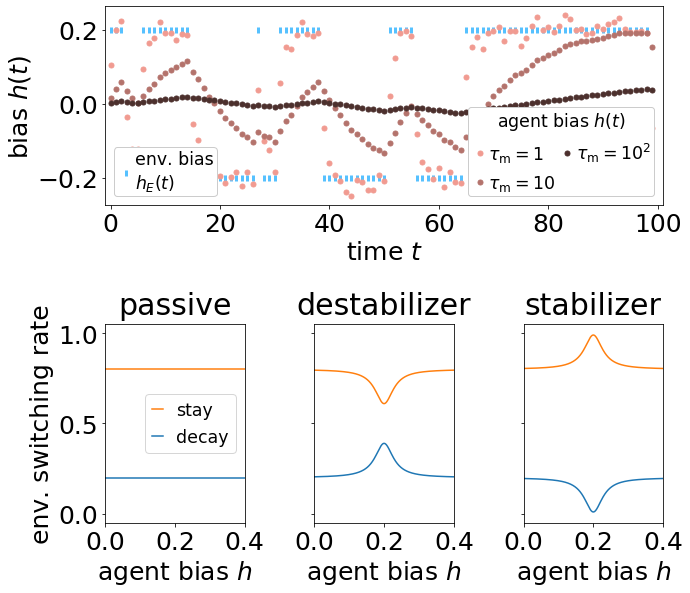

In [48]:
fig = plt.figure(figsize=(10,9.5))
gs = GridSpec(2,3)



# example trajectory ===================================
ax = fig.add_subplot(gs[0,:])

h = []

ix = where(learner.h[:100]>0)[0]
ax.plot(ix, learner.h[:100][ix], '|', c='#56C1FF', mew=3)
ix = where(learner.h[:100]<0)[0]
h.append(ax.plot(ix, learner.h[:100][ix], '|', c='#56C1FF', mew=3)[0])
h.append(ax.plot(learner.hhat[betaRange[0]][:100], '.', c='#F19B91', ms=10)[0])
h.append(ax.plot(learner.hhat[betaRange[1]][:100], '.', c='#B4736C', ms=10)[0])
h.append(ax.plot(learner.hhat[betaRange[2]][:100], '.', c='#4C302D', ms=10)[0])

ax.set(xlabel=r'time $t$', ylabel=r'bias $h(t)$', xlim=(-1,101))

# h.insert(0, Line2D([0], [0], marker='|', mew=3, ms=8, color='k', linewidth=0))
leg1 = ax.legend(h[:1], ('env. bias\n'+r'$h_E(t)$',),
                 fontsize='x-small', handletextpad=.0, borderpad=.2, ncol=2, handlelength=1,
                 columnspacing=.2, framealpha=1, loc=3)
leg2 = ax.legend(h[1:],
                  (r'$\tau_{\rm m}=1$', r'$\tau_{\rm m}=10$', r'$\tau_{\rm m}=10^2$'),
                  fontsize='x-small', handletextpad=.0, borderpad=.2, ncol=2, handlelength=1,
                  columnspacing=.2, framealpha=1, loc=4)
leg2.set_title(r'agent bias $h(t)$', prop={'size':'x-small'})
ax.add_artist(leg1)


# rate forms ============================================
ax = [fig.add_subplot(gs[1,i]) for i in range(3)]

h = linspace(0, .4, 1000)
h0 = .2
tau = 5
vd = .001  # dissipation
vs = .001  # stabilization
weight = .95


# passive
hand = []
hand.append(ax[0].plot(h, zeros_like(h)+1/tau)[0])
hand.append(ax[0].plot(h, ones_like(h)-1/tau)[0])
ax[0].set(xlabel=r'agent bias $h$', ylabel=r'env. switching rate')
ax[0].set_title('passive', pad=10)
ax[0].legend(hand[::-1], ('stay', 'decay'),
             fontsize='x-small', handlelength=.6)

# destabilizer
stay = binary_env_stay_rate(h-h0, tau, vd, -weight)
decay = 1 - stay

ax[1].plot(h, decay)
ax[1].plot(h, stay)
ax[1].set(xlabel=r'agent bias $h$')
ax[1].set_title('destabilizer', pad=10)

# stabilizer
stay = binary_env_stay_rate(h-h0, tau, vs, weight)
decay = 1 - stay

ax[2].plot(h, decay)
ax[2].plot(h, stay)
ax[2].set_title('stabilizer', pad=10)


for a in ax:
    a.set(xlabel=r'agent bias $h$', xlim=(0,.4),
          xticks=(0,.2,.4),
          ylim=(-.05,1.05))
for a in ax[1:]:
    a.set(yticklabels=[])
    

fig.subplots_adjust(wspace=.5, hspace=.6)

In [49]:
fig.savefig(f'{imgdr}/example_and_rates.pdf', bbox_inches='tight')

# Figure 2

Text(0.593, 0.136, 'D')

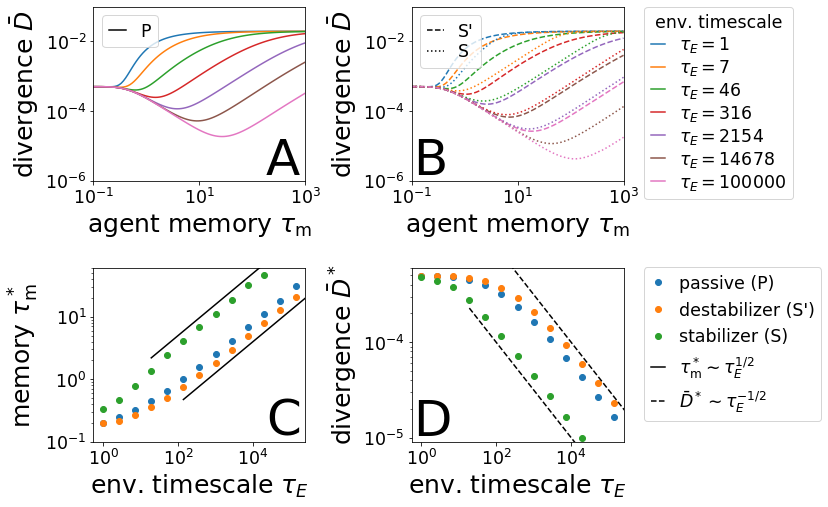

In [21]:
load_pickle('cache/vision_agent_sim_tau_range.p')
tauRange_ = tauRange
learners_ = learners
tauRange = tauRange[::2]
learners = learners[::2]
dkl_ = dkl.copy()
for k in list(dkl.keys())[1::2]:
    del dkl[k]

fig, ax = plt.subplots(figsize=(9.5,8), ncols=2, nrows=2,
                       gridspec_kw={'wspace':.5,'hspace':.5})
allax = ax
ax = [ax[0,0],ax[0,1]]


for i, mdkl in enumerate(dkl.values()):
    ax[0].loglog(-1/log(betaRange), mdkl, '-', c='C%d'%i)

ax[0].set(ylabel=r'divergence $\bar D$',
          xlim=-1/log(betaRange[[0,-1]]), ylim=(1e-6, .1),
          xlabel=r'agent memory $\tau_{\rm m}$',
          xticks=[.1, 10, 1e3])
leg = ax[0].legend([r'$\tau_E=%1.0f$'%(i) for i in tauRange],
                   fontsize='x-small',
                   loc=1,
                   ncol=1,
                   handlelength=.8,
                   columnspacing=.7,
                   handletextpad=.8,
                   labelspacing=.17,
                   bbox_to_anchor=(3.34,1.049))
leg.set_title('env. timescale',
              prop={'size':'x-small'})
leg.remove()

load_pickle('cache/destabilizer_agent_sim_tau_range.p')
tauRange_ = tauRange
learners_ = learners
tauRange = tauRange[::2]
learners = learners[::2]
dkl_ = dkl.copy()
for k in list(dkl.keys())[1::2]:
    del dkl[k]

for i, mdkl in enumerate(dkl.values()):
     ax[1].loglog(-1/log(betaRange), mdkl, '--')
        
load_pickle('cache/stabilizer_agent_sim_tau_range.p')
tauRange_ = tauRange
learners_ = learners
tauRange = tauRange[::2]
learners = learners[::2]
for k in list(dkl.keys())[1::2]:
    del dkl[k]

for i, mdkl in enumerate(dkl.values()):
     ax[1].loglog(-1/log(betaRange), mdkl, ':',
              c='C%d'%i)

ax[1].set(xlabel=r'agent memory $\tau_{\rm m}$',
          ylabel=r'divergence $\bar D$',
          xlim=-1/log(betaRange[[0,-1]]),
          ylim=(1e-6, .1),
          xticks=[.1, 10, 1e3])

custom_lines = [Line2D([0], [0], color='k'),
                Line2D([0], [0], linestyle='--', color='k'),
                Line2D([0], [0], linestyle=':', color='k')]
ax[0].legend(custom_lines,
             ('P',),
             fontsize='x-small',
             handlelength=1,
             labelspacing=.15,
             loc=2)
custom_lines = [Line2D([0], [0], linestyle='--', color='k'),
                Line2D([0], [0], linestyle=':', color='k')]
ax[1].legend(custom_lines,
             ("S'",'S'),
             fontsize='x-small',
             handlelength=1,
             labelspacing=.15,
             loc=2)
ax[1].add_artist(leg)

# ax[0].text(.12, 1.e-2, 'A', fontsize=50)
# ax[1].text(.12, 1.e-2, 'B', fontsize=50)



# ===============================================
ax = [allax[1,0],allax[1,1]]

# track min
load_pickle('cache/tau_scaling_0.2.p')

h = []

# passive
minbeta = []
mindkl = []
for k in list(Pdkl.keys())[:-2]:
    mn = find_chebmin(betaRange, Pdkl[k], h0, Perrs[k].ravel())
    minbeta.append(mn[0])
    mindkl.append(mn[1])
minbeta = np.array(minbeta)
mindkl = np.array(mindkl)
memlifetime = -1/log(minbeta)
h.append(ax[0].loglog(tauRange[:memlifetime.size], memlifetime, 'o')[0])
ax[1].loglog(tauRange[:mindkl.size], mindkl, 'o')

# destabilizer
minbeta = []
mindkl = []
for k in list(Pdkl.keys())[:-2]:
    mn = find_chebmin(betaRange, ADdkl[k], h0, ADerrs[k].ravel())
    minbeta.append(mn[0])
    mindkl.append(mn[1])
minbeta = np.array(minbeta)
mindkl = np.array(mindkl)
memlifetime = -1/log(minbeta)
h.append(ax[0].loglog(tauRange[:memlifetime.size], memlifetime, 'o')[0])
ax[1].loglog(tauRange[:mindkl.size], mindkl, 'o')

# stabilizer
minbeta = []
mindkl = []
for k in list(ASdkl.keys())[:-4]:
    mn = find_chebmin(betaRange, ASdkl[k], h0, ASerrs[k].ravel())
    minbeta.append(mn[0])
    mindkl.append(mn[1])
minbeta = np.array(minbeta)
mindkl = np.array(mindkl)
memlifetime = -1/log(minbeta)
h.append(ax[0].loglog(tauRange[:memlifetime.size], memlifetime, 'o')[0])
ax[1].loglog(tauRange[:mindkl.size], mindkl, 'o')

# fit lines
xlim0 = ax[0].get_xlim()
ylim0 = ax[0].get_ylim()
te = array([tauRange[5], xlim0[-1]])
h.append(ax[0].loglog(te, te**.5/25, 'k-')[0])
te = array([tauRange[3], xlim0[-1]])
ax[0].loglog(te, te**.5/2, 'k-')

ylim = ax[1].get_ylim()
te = tauRange[3:-3]
h.append(ax[1].loglog(te, te**-.5/1000, 'k--')[0])
te = tauRange[4:]
ax[1].loglog(te, te**-.5/100, 'k--')

ax[0].set(ylabel=r'memory $\tau_{\rm m}^*$')
ax[0].set(xscale='log', yscale='log')
ax[0].set(xlim=xlim0, ylim=(.1,ylim0[1]),
          xlabel=r'env. timescale $\tau_E$',
          xticks=[1, 1e2, 1e4])
ax[1].set(xscale='log', yscale='log',
          xlabel=r'env. timescale $\tau_E$',
          ylabel=r'divergence $\bar D^*$')
ax[1].set(xlim=xlim0, ylim=ylim)
ax[1].set(ylim=(1e-5/1.1,ylim[1]),
          xticks=[1, 1e2, 1e4])

ax[1].legend(h, ('passive (P)', "destabilizer (S')", 'stabilizer (S)',
                 r'$\tau_{\rm m}^* \sim \tau_E^{1/2}$',
                 r'$\bar D^* \sim \tau_E^{-1/2}$'),
             fontsize='x-small',
             handlelength=.8,
             bbox_to_anchor=(1.055,1.051))


# formatting all axes =============================================
for a in allax.ravel():
    [el.set_fontsize('x-small') for el in a.xaxis.get_ticklabels()]
    [el.set_fontsize('x-small') for el in a.yaxis.get_ticklabels()]

allax[0,0].text(180, 1.5e-6, 'A', fontsize=50)
allax[0,1].text(.105, 1.5e-6, 'B', fontsize=50)
fig.text(.377, .136, 'C', fontsize=50)
fig.text(.593, .136, 'D', fontsize=50)

In [22]:
fig.savefig(f'{imgdr}/tau_scaling.pdf', bbox_inches='tight')

# Figure 3

In [149]:
load_pickle('plotting/vision_benefits.p')

['scaleRange',
 'nBatchRange',
 'leftGrid',
 'rightGrid',
 'optimalMemGrid',
 'optunfitness']

/home/eddie/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


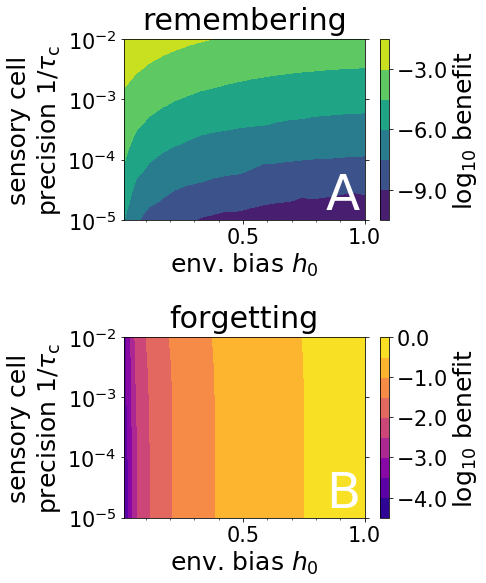

In [157]:
fig, ax = plt.subplots(figsize=(5.4,8.8), nrows=2)

# remembering
mat = log10(leftGrid)
mat[mat==-inf] = log10(leftGrid[leftGrid>0].min())
mat[mat<-10] = -10
cax = ax[0].contourf(scaleRange, 1/nBatchRange, mat, arange(-10.5,0,1.5))
ax[0].set(ylabel='sensory cell\n'+r'precision $1/\tau_{\rm c}$',
          yscale='log', xlabel=r'env. bias $h_0$')
ax[0].set_title('remembering', pad=10)
cbar = fig.colorbar(cax, ax=ax[0],
                    ticks=arange(-9,0,3),
                    label=r'$\log_{10}$ benefit', format='$%1.1f$')
labels = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(labels, {'size':'small'})

# forgetting
cax = ax[1].contourf(scaleRange, 1/nBatchRange, log10(rightGrid),
                     cmap=plt.cm.plasma)
ax[1].set(xlabel=r'env. bias $h_0$', ylabel='sensory cell\n'+r'precision $1/\tau_{\rm c}$',
          yscale='log')
ax[1].set_title('forgetting', pad=10)
cbar = fig.colorbar(cax, ax=ax[1],
                    ticks=range(-4,1),
                    label=r'$\log_{10}$ benefit',
                    format='%1.1f')
labels = cbar.ax.get_yticklabels()
[el.set_text(r'$%s$'%el.get_text()) for el in labels]
cbar.ax.set_yticklabels(labels, {'size':'small'})

# formatting
for ax_ in ax:
    ax_.set(yscale='log')
    ax_.xaxis.set_ticks(arange(.1,1.1,.1), minor=True)
    ax_.yaxis.set_ticks_position('both')
ax[0].set(yticks=[1e-2,1e-3,1e-4,1e-5], xticks=[.5,1])
ax[1].set(yticks=[1e-2,1e-3,1e-4,1e-5], xticks=[.5,1])

fig.subplots_adjust(hspace=.65)

ax[0].text(.84, 1.5e-5, 'A', color='white', size=50)
ax[1].text(.84, 1.5e-5, 'B', color='white', size=50)

for a in ax.ravel():
    [el.set_fontsize('small') for el in a.xaxis.get_ticklabels()]
    [el.set_fontsize('small') for el in a.yaxis.get_ticklabels()]

fig.savefig('%s/memory_v_forgetting.pdf'%imgdr, bbox_inches='tight')

# Part of Figure 4

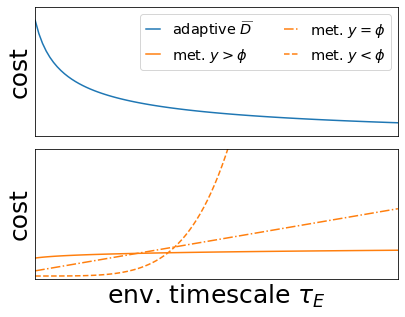

In [43]:
fig, ax = plt.subplots(figsize=(6.5,5), nrows=2, sharex=True)
h = []
te = linspace(.1, 2.5, 100)

h.append(ax[0].plot(te, te**-.5, '-')[0])

ax[0].set(xticks=[], yticks=[],
          ylabel=r'cost',
          ylim=(.3,3.5),
          xlim=(Ne.min(), Ne.max()))

h.append(ax[1].plot(te, te**.1, '-', c='C1')[0])
h.append(ax[1].plot(te, te+.2, '-.', c='C1')[0])
h.append(ax[1].plot(te, .1 + te**5, '--', c='C1')[0])

ax[1].set(xticks=[], yticks=[],
          xlabel=r'env. timescale $\tau_E$',
          ylabel=r'cost',
          ylim=(0, 5),
          xlim=(te.min(), te.max()))

ax[0].legend(h, (r'adaptive $\widebar{D}$', r'met. $y>\phi$', r'met. $y=\phi$', r'met. $y<\phi$'),
             fontsize='xx-small',
             handlelength=1,
             loc=1,
             ncol=2)

fig.subplots_adjust(hspace=.1)
fig.savefig(f'{imgdr}/metabolic_scaling.pdf', bbox_inches='tight')

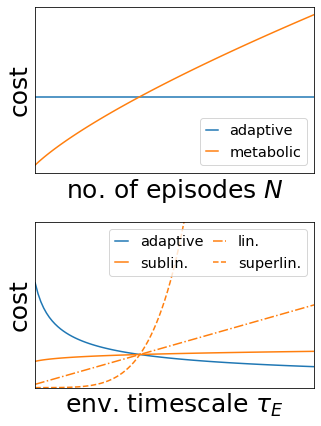

In [27]:
fig, ax = plt.subplots(figsize=(5,7), nrows=2)

Ne = linspace(.1, 2.5, 100)
ax[0].plot([Ne[0], Ne[-1]], [1,1], '-')
ax[0].plot(Ne, Ne**.75)

ax[0].set(xticks=[], yticks=[],
          xlabel=r'no. of episodes $N$',
          ylabel=r'cost',
          xlim=(Ne.min(), Ne.max()))

ax[0].legend(('adaptive', r'metabolic'),
             fontsize='xx-small',
             handlelength=.8,
             loc=4)


te = linspace(.1, 2.5, 100)
ax[1].plot(te, te**-.5, '-')
ax[1].plot(te, te**.1, '-', c='C1')
ax[1].plot(te, te, '-.', c='C1')
ax[1].plot(te, te**5, '--', c='C1')

ax[1].set(xticks=[], yticks=[],
          xlabel=r'env. timescale $\tau_E$',
          ylabel=r'cost',
          ylim=(0, 5),
          xlim=(te.min(), te.max()))

ax[1].legend(('adaptive', 'sublin.','lin.','superlin.'),
             fontsize='xx-small',
             handlelength=.9,
             ncol=2,
             columnspacing=.7)

fig.subplots_adjust(hspace=.3)
fig.savefig(f'{imgdr}/metabolic_scaling.pdf', bbox_inches='tight')

# Figure 5
From "cost tradeoff example.ipynb"

In [5]:
load_pickle('plotting/cost_tradeoff_example.p')
spline = interpolate(betaRange, dkl, .2, errs.ravel())
cost_spline = interpolate_cost(betaRange, cost, errs.ravel(), .2, 100,
                               {'weight':.95, 'v':.01})

In [6]:
?memory_cost

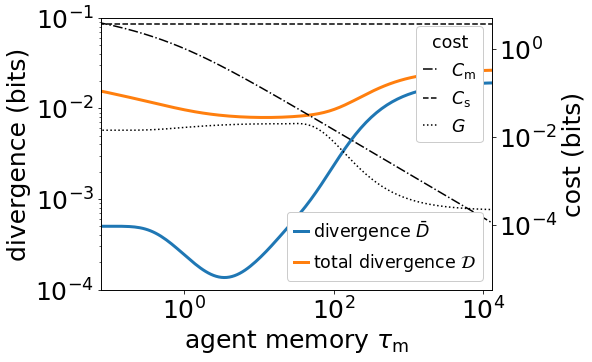

In [8]:
taRange = -1/log(betaPlot)

fig, ax = plt.subplots(figsize=(7,5))

ax.loglog(taRange, spline(betaPlot), lw=3)

totcost = cost_spline(betaPlot) / 100 + (memory_cost(taRange) + sensing_cost(1_000, .2))/500
ax.loglog(taRange, spline(betaPlot) + totcost, lw=3)

leg = ax.legend((r'divergence $\bar D$',r'total divergence $\mathcal{D}$'),
                framealpha=1,
                loc=4,
                fontsize='x-small',
                handlelength=.8,
                ncol=1,
                columnspacing=.9,
                handletextpad=.3)
# leg.set_title('unfitness', prop={'size':'x-small'})
leg.remove()

axb = ax.twinx()

taRange_ = logspace(log10(taRange[0]), log10(taRange[-1]), 1000)
axb.loglog(taRange_, memory_cost(taRange_), 'k-.')
axb.loglog(taRange, sensing_cost(1_000+zeros_like(taRange), .2), 'k--')
axb.loglog(taRange, cost_spline(betaPlot), 'k:')

axb.add_artist(leg)
legb = axb.legend((r'$C_{\rm m}$', r'$C_{\rm s}$', r'$G$'),
                  fontsize='x-small',
                  framealpha=1,
                  handlelength=.8,
                  loc=1)
legb.set_title('cost', prop={'size':'x-small'})

ax.set(xlabel=r'agent memory $\tau_{\rm m}$',
       ylabel='divergence (bits)', ylim=(1e-4,.1), xlim=(.1/1.3,1.3e4))
axb.set(ylabel='cost (bits)', ylim=(1e-5/3,5))

fig.savefig(f'{imgdr}/cost_tradeoff_example.pdf', bbox_inches='tight')

In [9]:
D = totcost + spline(betaPlot)
ix = where(r_[True,D[1:]<D[:-1]] & r_[D[:-1]<D[1:],True])
print(ix, taRange[ix])

(array([88]),) [12.45883364]


# Figure 6

In [1]:
load_pickle('plotting/competition1.p')

['optDivergD', 'optDivergS', 'chiRange', 'muRange']

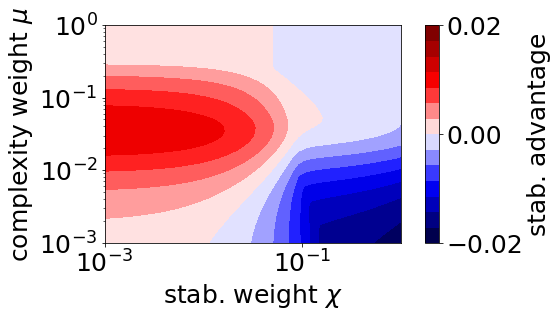

In [73]:
fig, ax = plt.subplots(ncols=2, gridspec_kw={'width_ratios':(1,.05), 'wspace':.15})
ax, cax = ax

d = optDivergD - optDivergS
dmx = ceil(abs(d).max()*100) / 100
ax.contourf(chiRange, muRange, d,
                  14, cmap=plt.cm.seismic, vmin=-dmx, vmax=dmx)
ax.set(xscale='log', yscale='log',
       xlabel=r'stab. weight $\chi$', ylabel=r'complexity weight $\mu$')

# create the new map
cmap = mpl.colors.ListedColormap([plt.cm.seismic(i) for i in linspace(0,1,14)])

# define the bins and normalize
# norm = mpl.colors.BoundaryNorm(linspace(-.02,.02,15), cmap.N)
norm = mpl.colors.BoundaryNorm(linspace(-dmx,dmx,cmap.N+1), cmap.N)
cb1 = mpl.colorbar.ColorbarBase(cax,
                                cmap=cmap,
                                norm=norm,
                                boundaries=linspace(-dmx,dmx,cmap.N+1),
                                ticks=(-.02,0,.02),
                                label='stab. advantage')

fig.savefig(f'{imgdr}/fitness_landscape.pdf', bbox_inches='tight')

# SI Figures

In [10]:
load_pickle('plotting/chebyshev_convergence.p')

['degreeRange', 'ldkl', 'lstabCost', 'dkl', 'errs', 'cost', 'h0', 'tau']

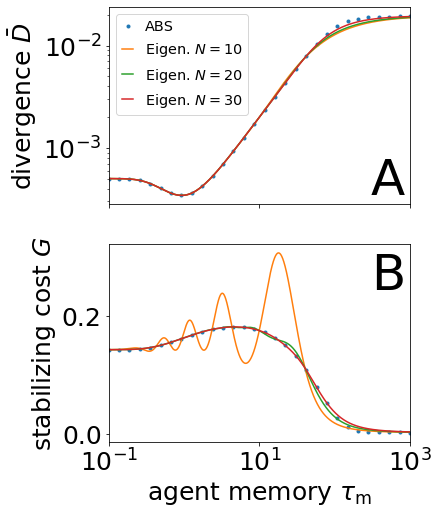

In [11]:
fig, ax = plt.subplots(figsize=(5.4, 8), nrows=2, sharex=True)

betaRange = linspace_beta(.1, 1000, 30)
ax[0].plot(-1/log(betaRange), ldkl, '.')

betaPlot = linspace(betaRange[0], .9999, 10000)
for i, d in enumerate(degreeRange):
    spline = interpolate(lobatto_beta(d), dkl[i], h0, errs=errs[i].ravel())
    ax[0].plot(-1/log(betaPlot), spline(betaPlot))

ax[0].set(ylabel=r'divergence $\bar D$',
          xscale='log', yscale='log')
ax[0].legend(('ABS', 'Eigen. $N=10$', 'Eigen. $N=20$', 'Eigen. $N=30$'),
             handlelength=.8,
             fontsize='xx-small')


betaRange = linspace_beta(.1, 1000, 30)
ax[1].plot(-1/log(betaRange), lstabCost, '.')

betaPlot = linspace(betaRange[0], .9999, 10000)
deg = zeros(len(degreeRange))
for i, d in enumerate(degreeRange):
    spline = interpolate_cost(lobatto_beta(d), cost[i], errs[i].ravel(), h0, tau,
                              {'weight':.95,'v':.01})
    deg[i] = (errs[i]<1e-4).sum()
    ax[1].plot(-1/log(betaPlot), spline(betaPlot))

ax[1].set(xlabel=r'agent memory $\tau_{\rm m}$', ylabel=r'stabilizing cost $G$',
          xscale='log')
ax[1].set(xlim=(-1/log(betaRange[0]), -1/log(betaRange[-1])))

ax[0].text(3e2, 3.5e-4, 'A', fontsize=50)
ax[1].text(3e2, .245, 'B', fontsize=50)

fig.savefig('%s/chebyshev_convergence.pdf'%imgdr, bbox_inches='tight')

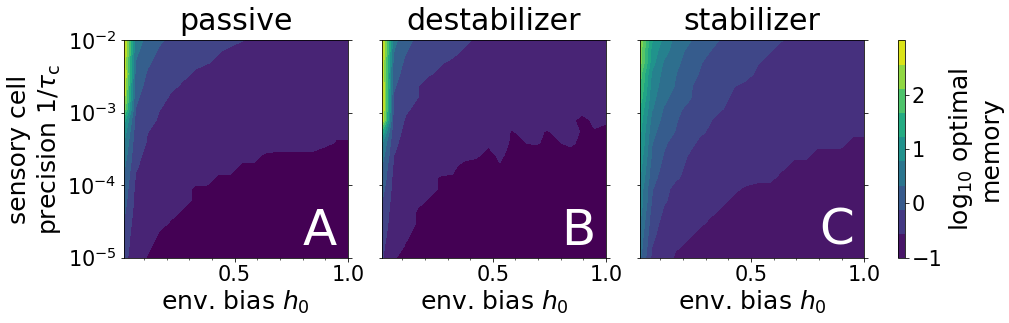

In [135]:
fig, ax = plt.subplots(figsize=(14,4), ncols=4, gridspec_kw={'width_ratios':(1,1,1,.03)})

load_pickle('plotting/vision_benefits.p')
grid1 = log10(optimalMemGrid)
load_pickle('plotting/destabilizer_benefits.p')
grid2 = log10(optimalMemGrid)
load_pickle('plotting/stabilizer_benefits.p')
grid3 = log10(optimalMemGrid)
vmn = -1#min(grid1.min(), grid2.min(), grid3.min())
vmx = max(grid1.max(), grid2.max(), grid3.max())

cax = ax[0].contourf(scaleRange, 1/nBatchRange, grid1, 10, vmin=vmn, vmax=vmx)
cax = ax[1].contourf(scaleRange, 1/nBatchRange, grid2, 10, vmin=vmn, vmax=vmx)
cax = ax[2].contourf(scaleRange, 1/nBatchRange, grid3, 10, vmin=vmn, vmax=vmx)

ax[0].set(ylabel='sensory cell\n'+r'precision $1/\tau_{\rm c}$')
ax[0].set_title('passive', pad=10)
ax[1].set_title('destabilizer', pad=10)
ax[2].set_title('stabilizer', pad=10)
for ax_ in ax[:3]:
    ax_.set(yscale='log', xlabel=r'env. bias $h_0$')
    ax_.set(yticks=(1e-5,1e-4,1e-3,1e-2))
    ax_.xaxis.set_ticks(arange(.1,1.1,.1), minor=True)
    ax_.yaxis.set_ticks_position('both')
for ax_ in ax[1:3]:
    ax_.set(yticklabels=[])
    
m = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
m.set_clim(vmn, vmx)
fig.colorbar(m, cax=ax[3], label=r'$\log_{10}$ optimal'+'\nmemory',
             boundaries=linspace(vmn,vmx,10), ticks=[-1,0,1,2])

ax[0].text(.8, 1.5e-5, 'A', color='white', size=50)
ax[1].text(.8, 1.5e-5, 'B', color='white', size=50)
ax[2].text(.8, 1.5e-5, 'C', color='white', size=50)

for a in ax.ravel():
    [el.set_fontsize('small') for el in a.xaxis.get_ticklabels()]
    [el.set_fontsize('small') for el in a.yaxis.get_ticklabels()]

fig.savefig('%s/opt_memory.pdf'%imgdr, bbox_inches='tight')

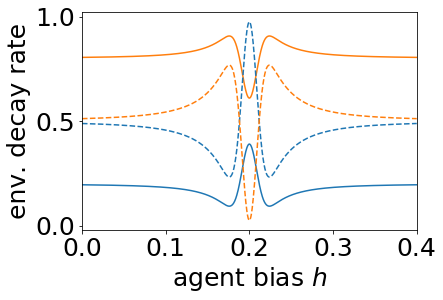

In [283]:
h = linspace(0, .4, 1000)
h0 = .2
tau = 5
vd = .001  # dissipation
vs = .001  # stabilization
weight = .95

fig, ax = plt.subplots()


# combination using Gaussian field
crossfade = exp(-(h-h0)**2/2/.01**2)
sstay = binary_env_stay_rate(h-h0, tau, vs, weight)
sdecay = 1 - sstay
dstay = binary_env_stay_rate(h-h0, tau, vd, -weight)
ddecay = 1 - dstay

stay = ((1-crossfade) * sstay + crossfade * dstay)
decay = ((1-crossfade) * sdecay + crossfade * ddecay)

ax.plot(h, decay)
ax.plot(h, stay)
ax.set(xlabel=r'agent bias $h$', ylabel='env. decay rate',
       xlim=(0,.4), ylim=(-.02, 1.02))

# tau = 2 =================================================
tau = 2

# combination using Gaussian field
crossfade = exp(-(h-h0)**2/2/.01**2)
sstay = binary_env_stay_rate(h-h0, tau, vs, weight)
sdecay = 1 - sstay
dstay = binary_env_stay_rate(h-h0, tau, vd, -weight)
ddecay = 1 - dstay
stay = ((1-crossfade) * sstay + crossfade * dstay)
decay = ((1-crossfade) * sdecay + crossfade * ddecay)

ax.plot(h, decay, '--', c='C0')
ax.plot(h, stay, '--', c='C1')

fig.savefig('%s/ant_rate_form.pdf'%imgdr, bbox_inches='tight')

In [14]:
tau = 20  # time scale for flipping external field
h0 = .2  # magnitude of external field
nBatch = 10_000
betaRange = [0,1/9,2/9,3/9]

load_pickle('cache/eigensolver_check_tau=%d.p'%tau)
# remember h is fixed for vision sim
ix = (abs(learner.h)<=inf) & (learner.h>0)
ix[:1000] = False

simx, simp = {}, {}
eigx, eigp = {}, {}
bins = linspace(-1, 1, 1000)

for beta in betaRange:
    p, x = histogram(learner.hhat[beta][ix], bins=bins)
    x = (x[1:] + x[:-1]) / 2
    p = p / p.sum()
    p /= bins[1] - bins[0]
    simx[beta] = x
    simp[beta] = p

    solver = eigen.Vision(tau, h0, beta, nBatch)
    # check that external conditioning still sums to the full solution
    phatavg, errflag, errs = solver.solve_external_cond()
    eigx[beta] = solver.x
    eigp[beta] = phatavg

Done in 1 steps.
Done in 7 steps.
Done in 10 steps.
Done in 14 steps.


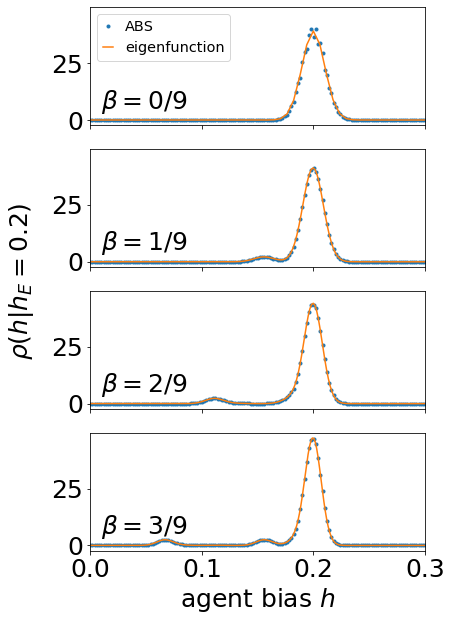

In [15]:
fig, ax = plt.subplots(figsize=(6,10), nrows=len(betaRange),
                       sharex=True, sharey=True)
ax = ax.ravel()

for i, beta in enumerate(betaRange):
    ax[i].plot(simx[beta], simp[beta], '.')
    ax[i].plot(eigx[beta], eigp[beta], '-')
    ax[i].text(.01, 5, r'$\beta=%d/9$'%i)
    
ax[0].legend(('ABS', 'eigenfunction'),
             fontsize='xx-small',
             handlelength=.7)
# ax[1].set(ylabel=r'$\rho(h|h_{\rm e}=h_0)$')

fig.text(0,.5, r'$\rho(h|h_E=0.2)$', rotation='vertical',
         horizontalalignment='right',
         verticalalignment='center')

ax[i].set(xlim=(0,.3), xlabel=r'agent bias $h$')
fig.savefig('%s/vision_cond_prob_check.pdf'%imgdr, bbox_inches='tight')

In [16]:
tau = 20  # time scale for flipping external field
h0 = .2  # magnitude of external field
nBatch = 10_000

load_pickle('cache/eigensolver_stig_check_tau=%d.p'%tau)
betaRange = [0,1/9,2/9,3/9]

simx, simp = {}, {}
eigx, eigp = {}, {}
bins = linspace(-1, 1, 1000)

for beta in betaRange:
    ix = (abs(learner.h[beta])<=inf) & (learner.h[beta]>0)
    ix[:1000] = False
    
    p, x = histogram(learner.hhat[beta][ix], bins=bins)
    x = (x[1:]+x[:-1])/2
    p = p / p.sum()
    p /= bins[1] - bins[0]
    simx[beta] = x
    simp[beta] = p

    solver = eigen.Stigmergy(tau, h0, beta, nBatch)
    # check that external conditioning still sums to the full solution
    phatavg, errflag, errs = solver.solve_external_cond()
    eigx[beta] = solver.x
    eigp[beta] = phatavg

Done in 1 steps.
Done in 8 steps.
Done in 11 steps.
Done in 15 steps.


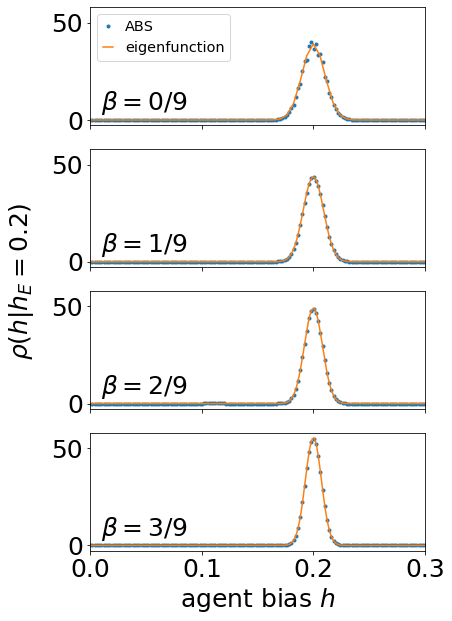

In [17]:
fig, ax = plt.subplots(figsize=(6,10), nrows=len(betaRange),
                       sharex=True, sharey=True)
ax = ax.ravel()

for i, beta in enumerate(betaRange):
    ax[i].plot(simx[beta], simp[beta], '.')
    ax[i].plot(eigx[beta], eigp[beta], '-')
    ax[i].text(.01, 5, r'$\beta=%d/9$'%i)
    
ax[0].legend(('ABS', 'eigenfunction'),
             fontsize='xx-small',
             handlelength=.7)
# ax[1].set(ylabel=r'$\rho(h|h_{\rm e}=h_0)$')

fig.text(0,.5, r'$\rho(h|h_E=0.2)$', rotation='vertical',
         horizontalalignment='right',
         verticalalignment='center')

ax[i].set(xlim=(0,.3), xlabel=r'agent bias $h$')
fig.savefig('%s/stig_cond_prob_check.pdf'%imgdr, bbox_inches='tight')

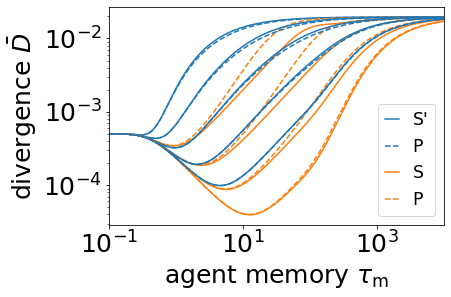

In [7]:
load_pickle('plotting/effective_timescales.p')

fig, ax = plt.subplots()
h = []

x = -1/log(betaPlot)
for i in range(5):
    h.append(ax.plot(x, y['destabilizer'][i], c='C0')[0])
    h.append(ax.plot(x, y['passive_ds'][i], '--', c='C0')[0])
    
    if i<4:
        h.append(ax.plot(x, y['stabilizer'][i], c='C1')[0])
        h.append(ax.plot(x, y['passive_s'][i], '--', c='C1')[0])

ax.set(xscale='log', yscale='log',
       xlabel=r'agent memory $\tau_{\rm m}$',
       ylabel=r'divergence $\bar{D}$', 
       xlim=(x[0], x[-1]))
ax.legend(h, ("S'","P",'S','P'), fontsize='x-small', handlelength=.8)

fig.savefig(f'{imgdr}/div_profile_similarity.pdf', bbox_inches='tight')

In [12]:
load_pickle('plotting/competition.p')

['landscapeS',
 'beta',
 'costGrid',
 'landscapeCost',
 'landscapeD',
 'betaRangePlot',
 'tcRange']

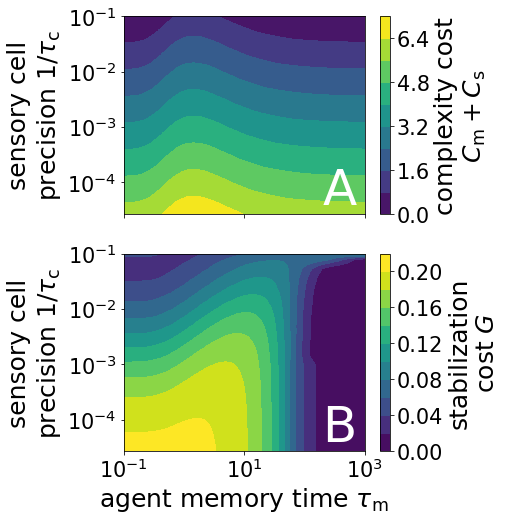

In [147]:
fig, ax = plt.subplots(figsize=(5.4,8), nrows=2,
                       gridspec_kw={'hspace':.2})
ax = ax.ravel()

mn = costGrid[:-3].min()
mx = costGrid[:-3].max()
cax = ax[0].contourf(-1/log(betaRangePlot), 1/tcRange[:-3], costGrid[:-3], 10,
                     vmin=mn, vmax=mx)
cbar = fig.colorbar(cax, ax=ax[0], label='complexity cost\n'+r'$C_{\rm m}+C_{\rm s}$',
             ticks=arange(0,7.2,1.6))
cbar.ax.tick_params(labelsize='small')

mn = landscapeCost[:-3].min()
mx = landscapeCost[:-3].max()
cax = ax[1].contourf(-1/log(betaRangePlot), 1/tcRange[:-3], landscapeCost[:-3], 10,
                     vmin=mn, vmax=mx)
cbar = fig.colorbar(cax, ax=ax[1], label='stabilization\n'+r'cost $G$')
cbar.ax.tick_params(labelsize='small')

ax[0].set(xscale='log', yscale='log',
          ylabel='sensory cell\n'+r'precision $1/\tau_{\rm c}$')
ax[0].set(xticklabels=[], yticks=(1e-4, 1e-3, 1e-2, 1e-1))
ax[1].set(xscale='log', yscale='log',
          xlabel=r'agent memory time $\tau_{\rm m}$',
          ylabel='sensory cell\n'+r'precision $1/\tau_{\rm c}$')
ax[1].set(yticks=(1e-4, 1e-3, 1e-2, 1e-1))

ax[0].text(2e2, 4e-5, 'A', color='white', size=50)
ax[1].text(2e2, 4e-5, 'B', color='white', size=50)

for a in ax.ravel():
    [el.set_fontsize('small') for el in a.xaxis.get_ticklabels()]
    [el.set_fontsize('small') for el in a.yaxis.get_ticklabels()]

fig.savefig(f'{imgdr}/costs.pdf', bbox_inches='tight')

In [12]:
load_pickle('plotting/competition.p')

['landscapeS',
 'beta',
 'costGrid',
 'landscapeCost',
 'landscapeD',
 'betaRangePlot',
 'tcRange']

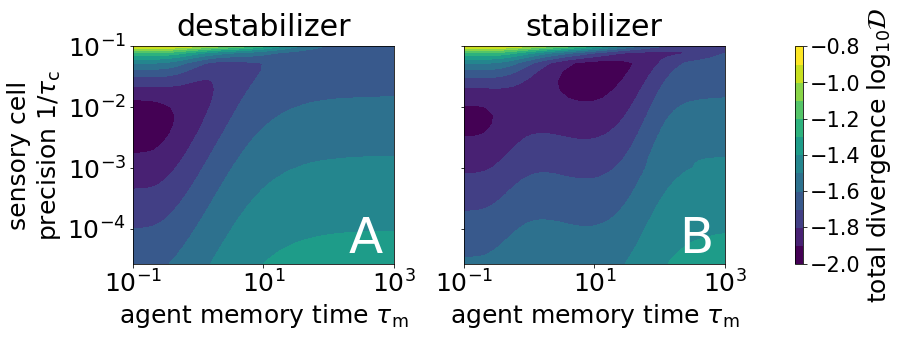

In [13]:
chi = .004
mu = .01

fig, ax = plt.subplots(figsize=(12,4), ncols=3, nrows=1,
                       gridspec_kw={'width_ratios':(1,1,.03),'wspace':.4})
ax = ax.ravel()


s = log10(landscapeS + chi * costGrid + mu * landscapeCost)
d = log10(landscapeD + chi * costGrid)
mn = min(s[:-3].min(), d[:-3].min())
mx = max(s[:-3].max(), d[:-3].max())

cax = ax[0].contourf(-1/log(betaRangePlot), 1/tcRange[:-3], d[:-3], 10,
                     vmin=mn, vmax=mx)
cax = ax[1].contourf(-1/log(betaRangePlot), 1/tcRange[:-3], s[:-3], 10,
                     vmin=mn, vmax=mx)

ax[0].set(xscale='log', yscale='log',
          xlabel=r'agent memory time $\tau_{\rm m}$',
          ylabel='sensory cell\n'+r'precision $1/\tau_{\rm c}$')
ax[0].set(yticks=(1e-4, 1e-3, 1e-2, 1e-1))
ax[1].set(xscale='log', yscale='log',
          xlabel=r'agent memory time $\tau_{\rm m}$')
ax[1].set(yticks=(1e-4, 1e-3, 1e-2, 1e-1))
ax[0].set_title('destabilizer', pad=10)
ax[1].set_title('stabilizer', pad=10)
ax[1].set(yticklabels=[])
cbar = fig.colorbar(cax, cax=ax[2], label=r'total divergence $\log_{10} \mathcal{D}$')
cbar.ax.tick_params(labelsize='small')

ax[0].text(2e2, 4e-5, 'A', color='white', size=50)
ax[1].text(2e2, 4e-5, 'B', color='white', size=50)

fig.savefig('%s/competition.pdf'%imgdr, bbox_inches='tight')